# Project Execution Summary

### Data Loading: Loaded orders.csv, users.json, and parsed restaurants.sql into Pandas DataFrames.

### Data Merging: Combined all three sources into a single dataset using Left Joins on user_id and restaurant_id.

### Preprocessing: Converted order_date to datetime, total_amount to numeric, and created a quarter column for seasonality.

### EDA: Analyzed monthly revenue trends, user spending behavior, and performance across cities and cuisines.

### Insights: Identified Chennai as the top city, Mexican as the top cuisine, and Q3 as the peak revenue season.

### Problem Solving: Calculated specific metrics like Gold member revenue and distinct user counts to answer all business questions.

In [26]:
import pandas as pd
import numpy as np
import re
import ast
import matplotlib.pyplot as plt
import seaborn as sns

In [27]:
# Merge Orders with Users
merged_df = pd.merge(orders_df, users_df, on='user_id', how='left')

# Merge with Restaurants
final_df = pd.merge(merged_df, restaurants_df, on='restaurant_id', how='left', suffixes=('', '_details'))

# Convert columns to correct types
final_df['total_amount'] = pd.to_numeric(final_df['total_amount'], errors='coerce')
final_df['order_date'] = pd.to_datetime(final_df['order_date'], dayfirst=True)
final_df['quarter'] = final_df['order_date'].dt.quarter

# Save the final file (Optional but recommended)
final_df.to_csv('final_food_delivery_dataset.csv', index=False)

In [13]:
print(final_df.info())
print(final_df.isnull().sum())
print(final_df.duplicated().sum())

monthly_trend = final_df.groupby('month_year')['total_amount'].sum()
monthly_trend.plot(kind='line', marker='o', figsize=(10, 5))
plt.show()

print(final_df['user_id'].value_counts().mean())
print(final_df['user_id'].value_counts().max())
print(final_df.groupby('user_id')['total_amount'].sum().nlargest(5))

print(final_df.groupby('city')['total_amount'].sum().sort_values(ascending=False))
print(final_df.groupby('cuisine')['total_amount'].sum().sort_values(ascending=False))

print(final_df.groupby('membership').agg({'total_amount': ['sum', 'mean'], 'order_id': 'count'}))

final_df.groupby('quarter')['total_amount'].sum().plot(kind='bar')
plt.show()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   order_id                 10000 non-null  int64         
 1   user_id                  10000 non-null  int64         
 2   restaurant_id            10000 non-null  int64         
 3   order_date               10000 non-null  datetime64[ns]
 4   total_amount             10000 non-null  float64       
 5   restaurant_name          10000 non-null  object        
 6   name                     10000 non-null  object        
 7   city                     10000 non-null  object        
 8   membership               10000 non-null  object        
 9   restaurant_name_details  10000 non-null  object        
 10  cuisine                  10000 non-null  object        
 11  rating                   10000 non-null  float64       
 12  quarter                  10000 no

KeyError: 'month_year'

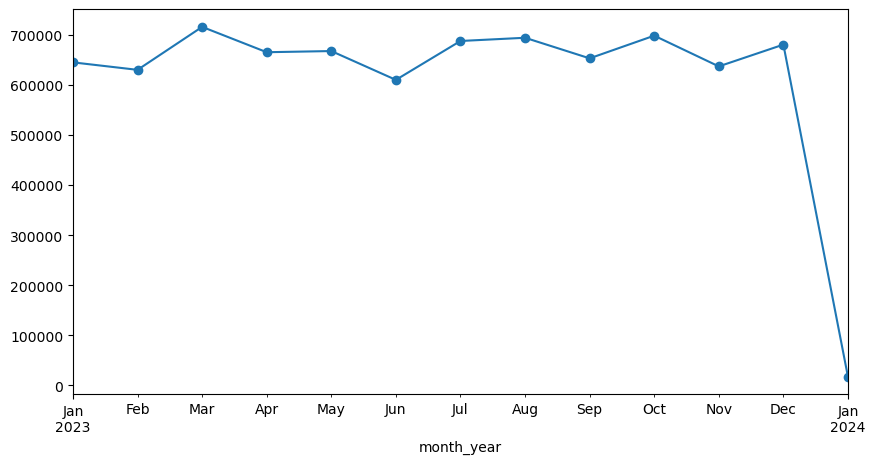

In [14]:
# Create the missing 'month_year' column first
final_df['month_year'] = final_df['order_date'].dt.to_period('M')

# Now calculate the trend and plot
monthly_trend = final_df.groupby('month_year')['total_amount'].sum()
monthly_trend.plot(kind='line', marker='o', figsize=(10, 5))
plt.show()

In [15]:
# 1. Load Orders (CSV)
orders_df = pd.read_csv('orders.csv')

# 2. Load Users (JSON)
users_df = pd.read_json('users.json')

# 3. Load Restaurants (SQL)
restaurant_data = []
with open('restaurants.sql', 'r') as f:
    for line in f:
        if line.strip().startswith("INSERT INTO restaurants VALUES"):
            match = re.search(r'\((.*)\);', line)
            if match:
                values_str = match.group(1)
                try:
                    row = ast.literal_eval(f"({values_str})")
                    restaurant_data.append(row)
                except:
                    pass

restaurants_df = pd.DataFrame(restaurant_data, columns=['restaurant_id', 'restaurant_name', 'cuisine', 'rating'])

In [16]:
gold_orders = final_df[final_df['membership'] == 'Gold']
q1_ans = gold_orders.groupby('city')['total_amount'].sum().sort_values(ascending=False)
print("Top City (Gold Revenue):", q1_ans.index[0])

Top City (Gold Revenue): Chennai


In [18]:
print(final_df.groupby('cuisine')['total_amount'].mean().sort_values(ascending=False).index[0])

Mexican


In [19]:
user_totals = final_df.groupby('user_id')['total_amount'].sum()
print((user_totals > 1000).sum())

2544


In [20]:
def get_rating_range(r):
    if 3.0 <= r <= 3.5: return '3.0 – 3.5'
    elif 3.6 <= r <= 4.0: return '3.6 – 4.0'
    elif 4.1 <= r <= 4.5: return '4.1 – 4.5'
    elif 4.6 <= r <= 5.0: return '4.6 – 5.0'
    return 'Other'

In [21]:
final_df['rating_range'] = final_df['rating'].apply(get_rating_range)
print(final_df.groupby('rating_range')['total_amount'].sum().sort_values(ascending=False).index[0])

4.6 – 5.0


In [22]:
print(gold_orders.groupby('city')['total_amount'].mean().sort_values(ascending=False).index[0])

print(restaurants_df.groupby('cuisine')['restaurant_id'].nunique().sort_values().index[0])

Chennai
Chinese


In [23]:
print(round((len(gold_orders) / len(final_df)) * 100))

50


In [24]:
rest_stats = final_df.groupby('restaurant_name').agg({'order_id':'count', 'total_amount':'mean'})
print(rest_stats[rest_stats['order_id'] < 20].sort_values(by='total_amount', ascending=False).index[0])

Hotel Dhaba Multicuisine


In [25]:
print(final_df.groupby(['membership', 'cuisine'])['total_amount'].sum().sort_values(ascending=False).index[0])

print(final_df.groupby('quarter')['total_amount'].sum().sort_values(ascending=False).index[0])

('Regular', 'Mexican')
3


In [30]:
print(len(final_df[final_df['membership'] == 'Gold']))

4987


In [31]:
print(round(final_df[final_df['city'] == 'Hyderabad']['total_amount'].sum()))

1889367


In [32]:
print(final_df['user_id'].nunique())

2883


In [33]:
print(round(final_df[final_df['membership'] == 'Gold']['total_amount'].mean(), 2))

print(len(final_df[final_df['rating'] >= 4.5]))

top_gold_city = gold_orders.groupby('city')['total_amount'].sum().sort_values(ascending=False).index[0]
print(len(gold_orders[gold_orders['city'] == top_gold_city]))

797.15
3374
1337
